# Predicting sales with a LSTM


In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import random as rd # generating random numbers
from datetime import datetime, date
from dateutil.relativedelta import relativedelta  # manipulating date formats
from math import ceil # math rounding up

# Visualization 
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Prediction
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import Adam, SGD, RMSprop

%matplotlib inline

/home/nadya/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Import all of the data 
train=pd.read_csv("../sales_train_v2.csv")
#train = pd.read_csv("../sales_train_v2.csv", parse_dates=['date'], infer_datetime_format=True, dayfirst=True)
item_cats=pd.read_csv("../item_categories.csv")
items=pd.read_csv("../items.csv")
sub=pd.read_csv("../sample_submission.csv")
shops=pd.read_csv("../shops.csv")
test=pd.read_csv("../test.csv")



## Data Exploration

In [3]:
# Check if all shop and items in the test set is also in the training set
train_items = train.item_id.unique()
test_items_not_in_train = test[~test.item_id.isin(train_items)].item_id.unique()
print('%d items in test data not found in train data' % len(test_items_not_in_train))

train_shops  = train.shop_id.unique()
test_shops_not_in_train = test[~test.shop_id.isin(train_shops)].shop_id.unique()
print('%d shops in test data not found in train data' % len(test_shops_not_in_train))

363 items in test data not found in train data
0 shops in test data not found in train data


In [15]:
train.tail()

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,month,year
2935841,22168,02.02.2013,1,42,799.0,1.0,62,02,2013
2935842,22168,17.02.2013,1,16,799.0,1.0,62,02,2013
2935843,22168,08.03.2013,2,43,798.5,1.0,62,03,2013
2935844,22168,13.09.2013,8,12,799.0,1.0,62,09,2013
2935845,22169,21.03.2014,14,25,4349.0,1.0,69,03,2014


In [17]:
test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


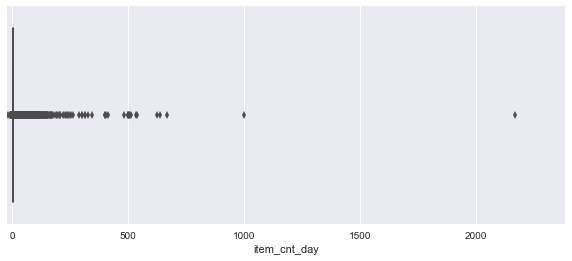

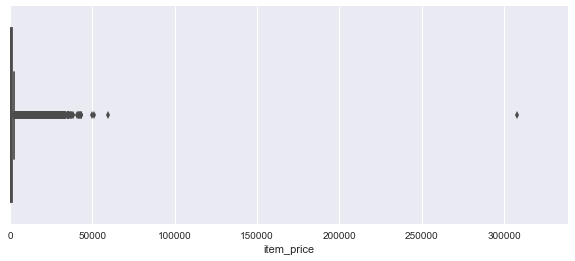

In [4]:
plt.figure(figsize=(10,4))
plt.xlim(train.item_cnt_day.min(), train.item_cnt_day.max()*1.1)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [5]:
# Remove outliers of prices and sales
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

In [6]:
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [7]:
# Fill item with price below zero with median
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()

train.loc[train.item_price<0, 'item_price'] = median

In [8]:
# Fix shops duplicates 

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

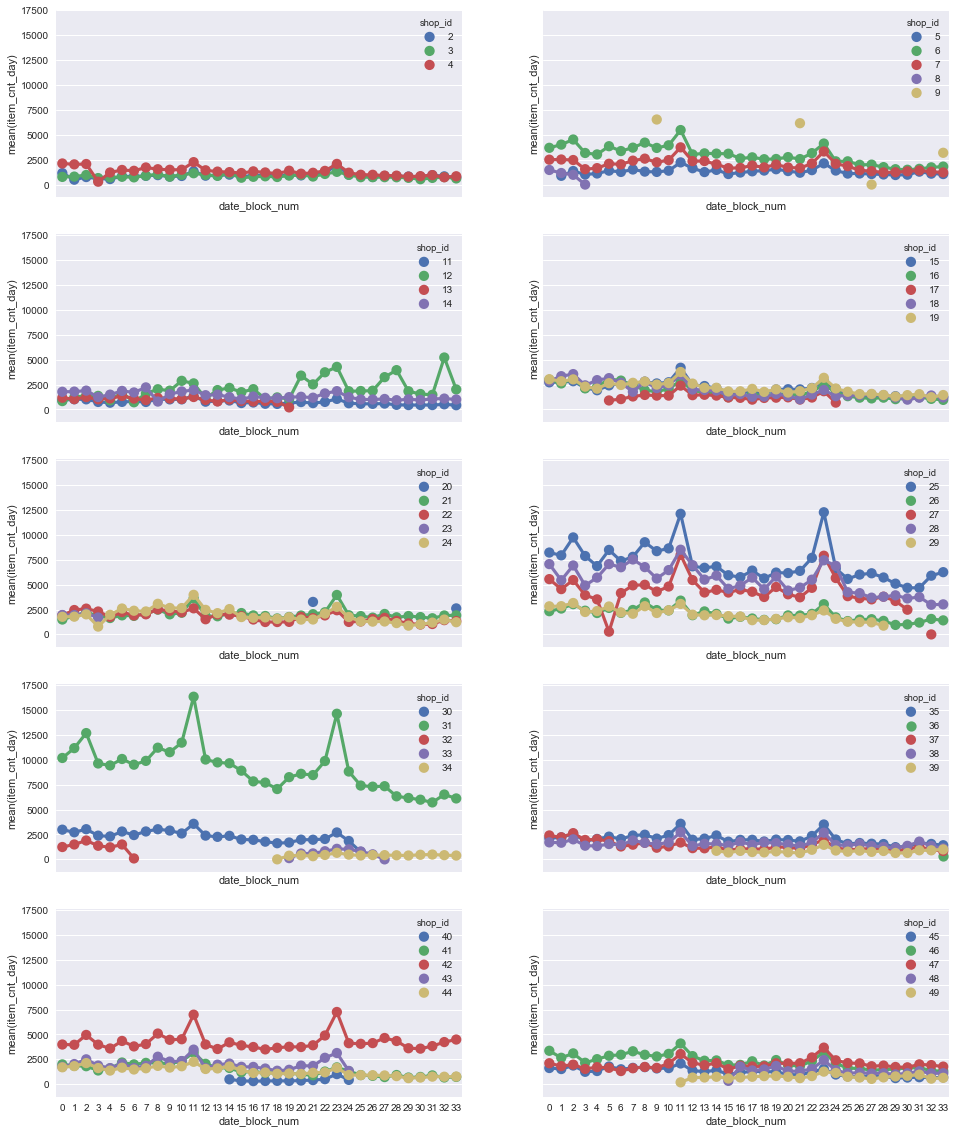

In [9]:
# Data visualisation
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

Clearly, there is a peak in shop shop at the end of the year, probably due to the holiday season. Therefore, it would be beneficial to add month and year, so that the network can pickup this pattern. It would be nice to see how each item sale is going. However, given the number of items, it would be more beneficial if we look at how each item categories is doing instead.

In [10]:
# Add categories to train set
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [11]:
# Add month and year to train set
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

In [12]:
train.head()

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,month,year
0,0,01.09.2014,20,54,58.0,1.0,40,09,2014
1,1,04.04.2014,15,55,4490.0,1.0,76,04,2014
2,1,02.04.2014,15,55,4490.0,1.0,76,04,2014
3,1,06.07.2014,18,55,4490.0,1.0,76,07,2014
4,1,04.08.2014,19,55,4490.0,1.0,76,08,2014


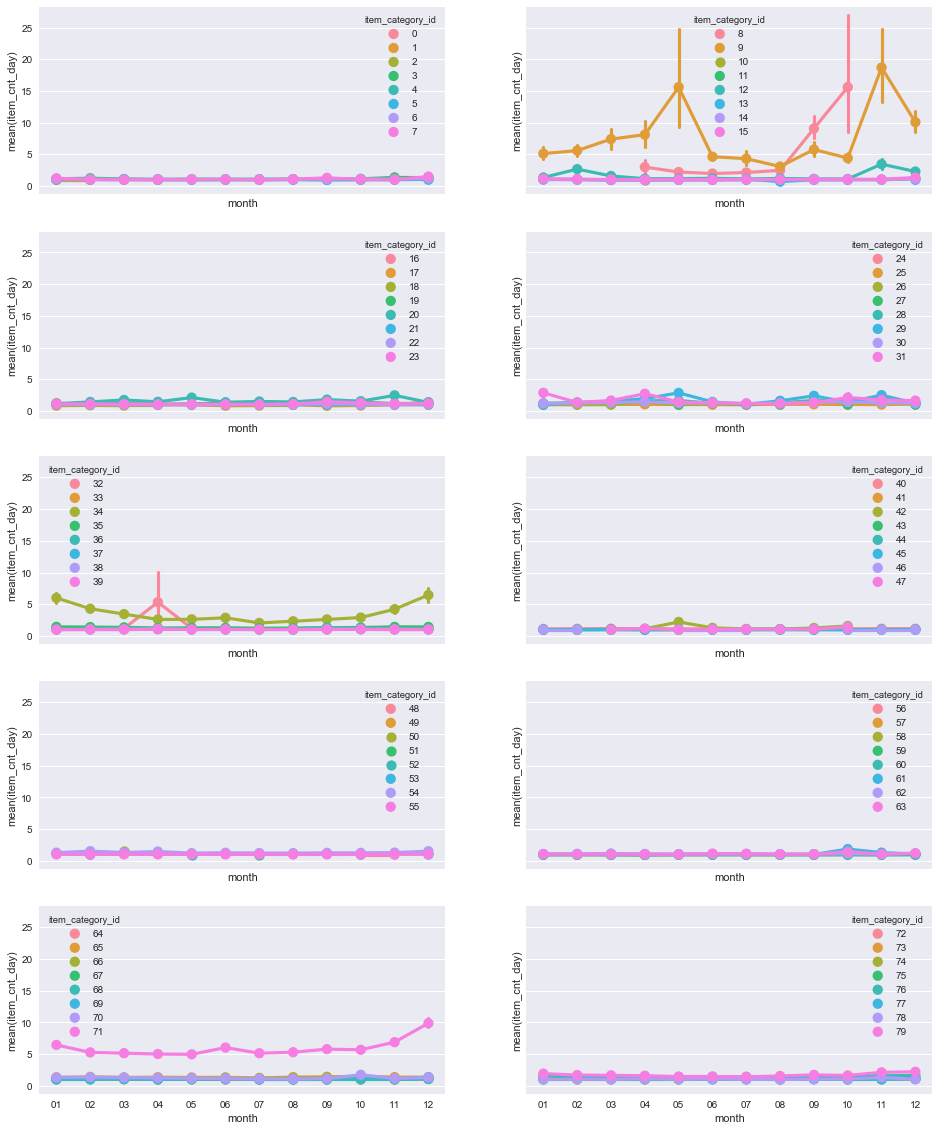

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

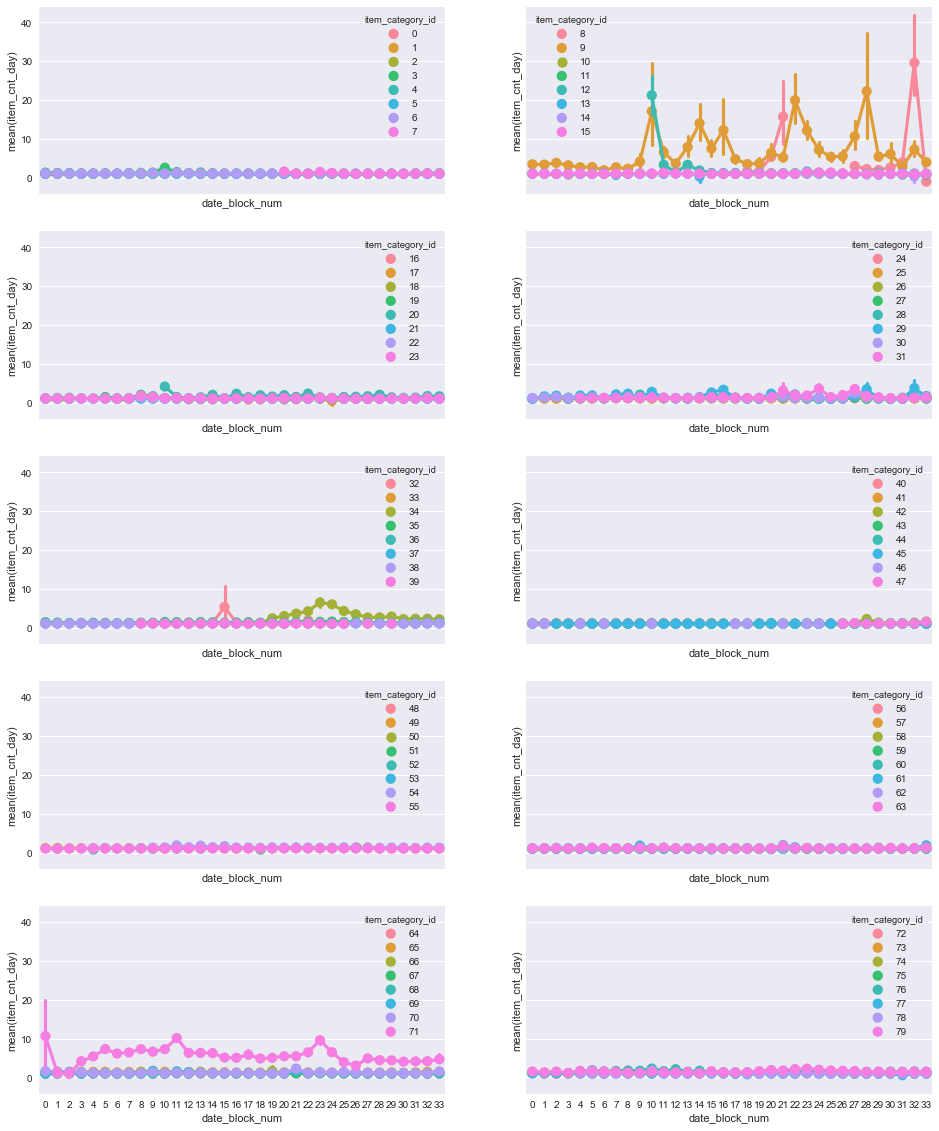

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1


In [19]:
train.tail()

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,month,year
2935841,22168,02.02.2013,1,42,799.0,1.0,62,02,2013
2935842,22168,17.02.2013,1,16,799.0,1.0,62,02,2013
2935843,22168,08.03.2013,2,43,798.5,1.0,62,03,2013
2935844,22168,13.09.2013,8,12,799.0,1.0,62,09,2013
2935845,22169,21.03.2014,14,25,4349.0,1.0,69,03,2014


### Training set and LSTM model

In [52]:
# Convert the train data to monthly sales, broken out by item & shop
train_raw = train.groupby([train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()
train_raw = train_raw[['date','item_id','shop_id','item_cnt_day']]
train_raw = train_raw.pivot_table(index=['item_id','shop_id'], columns='date',values='item_cnt_day',fill_value=0).reset_index()
train_raw.head()

date,item_id,shop_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Merge the monthly sales data to the test data
train_raw = pd.merge(test, train_raw, on=['item_id','shop_id'], how='left')
train_raw = train_raw.fillna(0)
train_raw.head()

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Remove the categorical data from the test data
train_raw = train_raw.drop(labels=['ID', 'shop_id', 'item_id'], axis=1)
train_raw.head()

,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Create ultimate training set. Use the '2015-10' sales column as the target to predict sales 
TARGET = '2015-10'
y_train = train_raw[TARGET]
X_train = train_raw.drop(labels=[TARGET], axis=1)

print(y_train.shape)
print(X_train.shape)
X_train.head()

(214200,)
(214200, 33)


,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# To make the training set friendly for keras, convert it to a numpy matrix
X_train = X_train.as_matrix()
X_train = X_train.reshape((214200, 33, 1))

y_train = y_train.as_matrix()
y_train = y_train.reshape(214200, 1)

print(y_train.shape)
print(X_train.shape)

X_train[:1]

(214200, 1)
(214200, 33, 1)


array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [3.],
        [1.]]])

In [35]:
# Drop the first month so that trained LSTM can output predictions beyond the known time range
X_test = train_raw.drop(labels=['2013-01'],axis=1)
X_test = X_test.as_matrix()
X_test = X_test.reshape((214200, 33, 1))
print(X_test.shape)

(214200, 33, 1)


In [32]:
# Create the model using the LSTM 
model = Sequential()
model.add(LSTM(64, input_shape=(33, 1), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))

# The adam optimizer
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Training 
BATCH = 2000

print('Training...')
model.fit(X_train, y_train,
          batch_size=BATCH,
          epochs=10
         )

Training time, it is...
Epoch 1/10
214200/214200 [==============================] - 78s 362us/step - loss: 6.8885 - mean_squared_error: 6.8885
Epoch 2/10
214200/214200 [==============================] - 78s 365us/step - loss: 6.6025 - mean_squared_error: 6.6025
Epoch 3/10
214200/214200 [==============================] - 87s 406us/step - loss: 6.4934 - mean_squared_error: 6.4934
Epoch 4/10
214200/214200 [==============================] - 96s 448us/step - loss: 6.4128 - mean_squared_error: 6.4128
Epoch 5/10
214200/214200 [==============================] - 81s 376us/step - loss: 6.2982 - mean_squared_error: 6.2982
Epoch 6/10
214200/214200 [==============================] - 89s 414us/step - loss: 6.2085 - mean_squared_error: 6.2085
Epoch 7/10
214200/214200 [==============================] - 83s 387us/step - loss: 6.1742 - mean_squared_error: 6.1742
Epoch 8/10
214200/214200 [==============================] - 80s 374us/step - loss: 6.1535 - mean_squared_error: 6.1535
Epoch 9/10
214200/214200

In [36]:
# Get the test set predictions and clip values to the specified range
y_pred = model.predict(X_test).clip(0., 20.)

# Create the submission file and submit!
preds = pd.DataFrame(y_pred, columns=['item_cnt_month'])
preds.to_csv('submission.csv',index_label='ID')